### ⚙️ 환경 설정

`pip install -qU langgraph langchain-core langchain-openai graphiti-core`

`pip install -r requirements.txt`

In [2]:
import asyncio
import json
import logging
from logging import INFO
import os
from datetime import datetime, timezone, timedelta

from dotenv import load_dotenv

from graphiti_core import Graphiti
from graphiti_core.nodes import EpisodeType
from graphiti_core.search.search_config_recipes import NODE_HYBRID_SEARCH_RRF

In [3]:
logging.basicConfig(
    level=INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)
logger = logging.getLogger(__name__)

load_dotenv()

neo4j_uri = os.environ.get('NEO4J_URI')
neo4j_user = os.environ.get('NEO4J_USERNAME')
neo4j_password = os.environ.get('NEO4J_PASSWORD')

if not neo4j_uri or not neo4j_user or not neo4j_password:
    raise ValueError('NEO4J_URI, NEO4J_USERNAME, and NEO4J_PASSWORD must be set')

## 🧑‍💻 Graphiti 사용하기

In [ ]:
graphiti = Graphiti(neo4j_uri, neo4j_user, neo4j_password)

await graphiti.build_indices_and_constraints()

### 1) 에피소드 추가

- 에피소드는 Graphiti의 기본 정보 단위

**에피소드 유형**

- `text`: 비정형 텍스트 데이터

- `message`: 대화형 메시지 형식
    - speaker: message...

- `json`: 다른 유형과는 별도로 처리되는 구조화된 데이터

In [4]:
episodes = [
    {
        'name': 'OpenAI',
        'content': {
            "name": "OpenAI",
            "founded": "2015-12-8",
            "founders": "Sam Altman",
            "type": "AI 연구 개발 기업",
            "official_website": "https://openai.com/",
        },
        'type': EpisodeType.json,
        'description': 'article metadata',
    },
    {
        'name': 'OpenAI의 기본 모델',
        'content': '2024년 5월 기준, OpenAI의 기본 모델은 GPT-4o입니다.',
        'type': EpisodeType.text,
        'description': 'news article',
    }
]

print(f"총 {len(episodes)}개의 에피소드가 정의되었습니다.")

총 2개의 에피소드가 정의되었습니다.


In [ ]:
for i, episode in enumerate(episodes):
    await graphiti.add_episode(
        name=episode['name'],
        episode_body=episode['content']
        if isinstance(episode['content'], str)
        else json.dumps(episode['content']),
        source=episode['type'],
        source_description=episode['description'],
        reference_time=datetime.now(timezone.utc),
    )
    print(f'Added episode: {episode["name"]} ({episode["type"].value})')

새로운 에피소드 추가!

In [6]:
episodes = [
    {
        'name': '새로운 모델 출시',
        'content': 'OpenAI의 현재 기본 모델은 8월 8일부로 GPT-5로 변경되었습니다.'
        'GPT-5는 전반적으로 훨씬 더 스마트하며, 특히 수학, 코딩, 시각적 인식, 의료 분야의 학술적 및 인간 평가 벤치마크에서의 성과에서 확인할 수 있습니다. '
        '수학(도구 없이 AIME 2025에서 94.6%), 실제 코딩(SWEBench에서 74.9%, 에이더 폴리글롯에서 88%), 멀티모달 이해(MMU에서 84.2$), 의료(HealthBench Hard에서 46.2%) 전반에서 새롭게 최고 기록을 세웠으며 이러한 이점은 일상 사용에도 적용됩니다. ',
        'type': EpisodeType.text,
        'description': 'news article',
    }
]

print(f"총 {len(episodes)}개의 에피소드가 정의되었습니다.")

총 1개의 에피소드가 정의되었습니다.


In [ ]:
for i, episode in enumerate(episodes):
    await graphiti.add_episode(
        name=episode['name'],
        episode_body=episode['content']
        if isinstance(episode['content'], str)
        else json.dumps(episode['content']),
        source=episode['type'],
        source_description=episode['description'],
        reference_time=datetime.now(timezone.utc),
    )
    print(f'Added episode: {episode["name"]} ({episode["type"].value})')

### 2) 검색

1) 기본 검색 (엣지 검색)

In [ ]:
query = "OpenAI의 정보를 알려주세요."
print(f"검색 중: '{query}'")
results = await graphiti.search(query)

print('\n검색 결과:')
for result in results:
    print(f'UUID: {result.uuid}')
    print(f'Fact: {result.fact}')
    if hasattr(result, 'valid_at') and result.valid_at:
        print(f'Valid from: {result.valid_at}')
    if hasattr(result, 'invalid_at') and result.invalid_at:
        print(f'Valid until: {result.invalid_at}')
    print('---')

2) 중심 노드 기반 검색 (엣지 검색)

In [ ]:
query = "OpenAI의 정보를 알려주세요."

# 상위 검색 결과의 소스 노드 UUID를 중심 노드로 사용
center_node_uuid = results[0].source_node_uuid

print('\n그래프 거리를 기반으로 검색 결과 재정렬:')
print(f'중심 노드 UUID 사용: {center_node_uuid}')

reranked_results = await graphiti.search(
    query, center_node_uuid=center_node_uuid
)

print('\n재정렬된 검색 결과:')
for result in reranked_results:
    print(f'UUID: {result.uuid}')
    print(f'Fact: {result.fact}')
    if hasattr(result, 'valid_at') and result.valid_at:
        print(f'Valid from: {result.valid_at}')
    if hasattr(result, 'invalid_at') and result.invalid_at:
        print(f'Valid until: {result.invalid_at}')
    print('---')

3) 검색 레시피 사용 (NODE_HYBRID_SEARCH_RRF) 하여 노드 검색

In [ ]:
node_search_config = NODE_HYBRID_SEARCH_RRF.model_copy(deep=True)
node_search_config.limit = 5

node_search_results = await graphiti._search(
    query='gpt-5',
    config=node_search_config,
)

print('\n노드 검색 결과:')
for node in node_search_results.nodes:
    print(f'Node UUID: {node.uuid}')
    print(f'Node Name: {node.name}')
    node_summary = node.summary[:100] + '...' if len(node.summary) > 100 else node.summary
    print(f'Content Summary: {node_summary}')
    print(f'Node Labels: {", ".join(node.labels)}')
    print(f'Created At: {node.created_at}')
    if hasattr(node, 'attributes') and node.attributes:
        print('Attributes:')
        for key, value in node.attributes.items():
            print(f'  {key}: {value}')
    print('---')

In [ ]:
# await graphiti.close()

## 🤖 Agent

In [5]:
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode

In [6]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

### 🔧 에피소드 저장 & 호출 도구

1) 에피소드 저장 도구

In [7]:
@tool
async def save_episode(
    name: str,
    content: str,
    episode_type: str = "text",
    description: str = "User conversation episode"
) -> str:
    """
    사용자가 제공한 정보를 저장합니다. 정보가 특정 시점에 한정된다면 시간 정보를 함께 저장해야 합니다.

    Args:
        name (str): 에피소드의 이름 또는 제목
        content (str): 에피소드의 내용 (텍스트 또는 JSON 문자열)
        episode_type (str): 에피소드 타입 ('text', 'json', 'message' 중 하나, 기본값: 'text')
        description (str): 에피소드에 대한 설명 (기본값: 'User conversation episode')

    Returns:
        str: 저장 결과 메시지
    """
    try:
        episode_type_map = {
            'text': EpisodeType.text,
            'json': EpisodeType.json,
            'message': EpisodeType.message
        }

        ep_type = episode_type_map.get(episode_type.lower(), EpisodeType.text)

        await graphiti.add_episode(
            name=name,
            episode_body=content,
            source=ep_type,
            source_description=description,
            reference_time=datetime.now(timezone.utc),
        )

        return f"에피소드 '{name}'이 성공적으로 저장되었습니다. (타입: {episode_type})"

    except Exception as e:
        return f"에피소드 저장 중 오류가 발생했습니다: {str(e)}"

In [14]:
tools = [save_episode]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
query = """
아래 내용 저장해주세요.

네이버가 인공지능(AI) 기술을 적용한 새로운 ‘맞춤형 검색’을 도입했다.
이용자의 기존 검색 이력을 보여주는 대신 AI 추천 검색어와 숏폼 콘텐츠를 띄우는 식이다.
카카오도 다음달 AI가 접목된 카카오톡 개편 방향을 공개할 예정이어서 두 대형 플랫폼의 AI 서비스 경쟁이 본격화하고 있다.
"""
await ToolNode(tools).ainvoke({'messages': [llm_with_tools.invoke(query)]})

2) 에피소드 검색 도구

In [8]:
def edges_to_facts_string(edges):
    """
    엣지 검색 결과를 문자열로 변환하는 헬퍼 함수
    """
    if not edges:
        return "관련 정보를 찾을 수 없습니다."

    current_time = datetime.now(timezone.utc)

    def is_expired(edge):
        if not (hasattr(edge, 'invalid_at') and edge.invalid_at):
            return False
        try:
            invalid_time = edge.invalid_at
            if isinstance(invalid_time, str):
                invalid_time = datetime.fromisoformat(invalid_time.replace('Z', '+00:00'))
            if invalid_time.tzinfo is None:
                invalid_time = invalid_time.replace(tzinfo=timezone.utc)
            return current_time > invalid_time
        except:
            return False

    def get_fact_content(edge):
        return edge.fact if hasattr(edge, 'fact') and edge.fact else str(edge)

    valid_facts = [get_fact_content(edge) for edge in edges if not is_expired(edge)]
    expired_count = len(edges) - len(valid_facts)

    if not valid_facts:
        return f"관련 정보가 있었지만 모두 만료되었습니다. (만료된 정보 {expired_count}개)" if expired_count else "관련 정보를 찾을 수 없습니다."

    result = "=== 현재 유효한 정보 ===\n" + "\n".join(valid_facts)
    if expired_count:
        result += f"\n\n[필터링 정보: 유효 {len(valid_facts)}개, 만료 {expired_count}개 제외됨]"

    return result

In [9]:
@tool
async def get_memory(
    query: str,
) -> str:
    """
    사용자와의 대화 기록이나 저장된 정보를 검색하여 질문에 답할 때 사용합니다. (만료된 정보 필터링 포함)

    Args:
        query (str): 검색할 쿼리

    Returns:
        str: 검색 결과 (유효한 정보만 또는 모든 정보)
    """
    try:
        edge_results = await graphiti.search(
            query,
            num_results=5
        )

        return edges_to_facts_string(edge_results)

    except Exception as e:
        return f"정보 검색 중 오류가 발생했습니다: {str(e)}"

In [18]:
tools = [get_memory]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
query = """
OpenAI의 현재 정보를 알려주세요.
"""
tool_response = await ToolNode(tools).ainvoke({'messages': [llm_with_tools.invoke(query)]})
tool_response

In [ ]:
print(tool_response["messages"][0].content)

### 🧠 도구 기반 에이전트 생성

In [10]:
import uuid
from typing_extensions import TypedDict
from typing import Annotated

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, add_messages

In [11]:
tools = [save_episode, get_memory]
tool_node = ToolNode(tools)

1) ReAct 에이전트

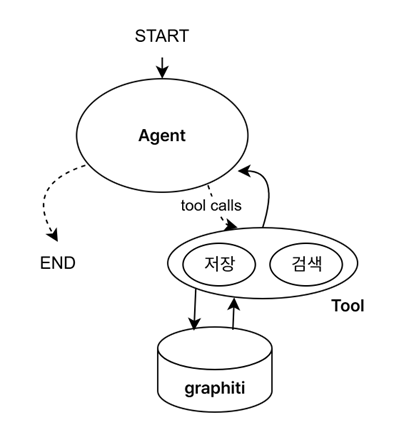

In [23]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    llm,
    tools,
    prompt="""
    당신은 최신 정보를 저장하고 이를 기반으로 답변하는 지능형 에이전트입니다.
    사용자가 입력한 정보를 저장하거나, 저장된 최신 정보를 기반으로 사용자의 질문에 정확하고 도움이 되는 답변을 제공해야 합니다.

    답변 시 유의사항:
    - 간결하고 명확하게 답변하세요.
    - 저장된 정보가 부족하거나 날짜에 관한 추가 정보가 필요하다면 사용자에게 다시 물어보세요.
    - 최신 정보를 우선적으로 활용하여 답변하세요.
    """
)

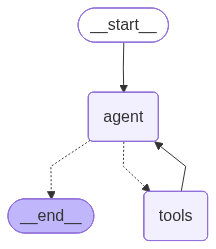

In [24]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
query = """
2형 당뇨병의 원인을 찾아서 알려주세요.
"""

result = await agent.ainvoke(
    {
        'messages': [
            {
                'role': 'user',
                'content': query,
            }
        ],
    },
    config={'configurable': {'thread_id': uuid.uuid4().hex}},
)

In [ ]:
for msg in result["messages"]:
    msg.pretty_print()

2) 커스텀 Agent

In [14]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_name: str
    user_node_uuid: str

In [15]:
tools = [save_episode, get_memory]
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

In [16]:
async def chatbot(state: State):
    ### 기반 정보 검색
    facts_string = None
    if len(state['messages']) > 0:
        last_message = state['messages'][-1]
        print(f"last_message: {last_message}")
        graphiti_query = f'{"AI" if isinstance(last_message, AIMessage) else state["user_name"]}: {last_message.content}'
        print(f"graphiti_query: {graphiti_query}")
        edge_results = await graphiti.search(
            graphiti_query,
            center_node_uuid=state["user_node_uuid"],
            num_results=5
        )
        print("edge_results", edge_results)
        facts_string = edges_to_facts_string(edge_results)
        print(f"facts_string: {facts_string}")

    ### LLM 설정 및 응답 생성
    system_message = SystemMessage(
        content=f"""당신은 최신 정보를 저장하고 이를 기반으로 답변하는 지능형 에이전트입니다.
        사용자가 입력한 정보를 저장하거나, 저장된 최신 정보를 기반으로 사용자의 질문에 정확하고 도움이 되는 답변을 제공해야 합니다.
        특히 사용자의 메모리에 담긴 취향이나 정보를 검색해서 적절한 답변을 할 수 있습니다.

        사용 가능한 도구:
        - save_episode: 사용자가 제공한 정보를 저장합니다. 정보가 특정 시점에 한정된다면 시간 정보를 함께 저장해야 합니다.
        - get_memory: 사용자와의 대화 기록이나 저장된 정보를 검색하여 질문에 답할 때 사용합니다.

        답변 시 유의사항:
        - 간결하고 명확하게 답변하세요.
        - 저장된 정보가 부족하거나 추가 정보가 필요하다면 사용자에게 다시 물어보세요.
        - 최신 정보를 우선적으로 활용하여 답변하세요.

        사용자 관련 정보 및 대화 기록:
        {facts_string}"""
    )

    messages = [system_message] + state['messages']

    response = await llm_with_tools.ainvoke(messages)

    ### 채팅 내용 저장
    if not response.tool_calls:
        asyncio.create_task(
            graphiti.add_episode(
                name='Chatbot Response',
                episode_body=f'{state["user_name"]}: {state["messages"][0]}\nAI: {response.content}',
                source=EpisodeType.message,
                reference_time=datetime.now(timezone.utc),
                source_description='Chatbot',
            )
        )

    print("response", response)
    print()
    return {'messages': [response]}

In [17]:
async def should_continue(state, config):
    messages = state['messages']
    last_message = messages[-1]
    if not last_message.tool_calls:
        return 'end'
    else:
        return 'continue'

In [18]:
graph_builder = StateGraph(State)
memory = MemorySaver()

graph_builder.add_node('agent', chatbot)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges('agent', should_continue, {'continue': 'tools', 'end': END})
graph_builder.add_edge('tools', 'agent')

graph = graph_builder.compile(checkpointer=memory)

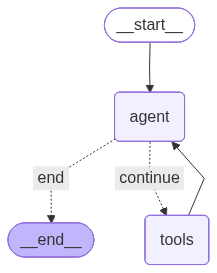

In [19]:
graph

In [ ]:
history = [
    {
        "messages": """
            nayeon: 얼마 전에 좀비딸 영화 봤는데 재밌더라. 그게 웹툰도 재밌었거든.
            AI: 오, 좀비딸 영화와 웹툰이라니 흥미롭네요! 좀비딸 웹툰은 어떤 점이 특히 재미있었나요?
        """
    },
    {
        "messages": """
            nayeon: 내가 원래 재난 영화를 좋아하는데, 이건 코미디도 섞여서 더 재미있었어.
            AI: 재난 영화에 코미디 요소가 더해지면 긴장감도 풀리고 재미가 배가되죠. 혹시 영화에서 가장 기억에 남는 장면이 있었나요?
        """
    },
]

for chat in history:
    await graphiti.add_episode(
        name='Chatbot Response',
        episode_body=chat["messages"],
        source=EpisodeType.message,
        reference_time=datetime.now(timezone.utc),
        source_description='Chatbot',
    )

In [ ]:
user_name = "nayeon"
user_node_uuid = "" # TODO: 사용자 UUID 가져오기
thread_id = uuid.uuid4().hex

In [ ]:
result = await graph.ainvoke(
    {
        'messages': [
            {
                'role': 'user',
                'content': '떡볶이 먹고 장염 걸렸어ㅠㅠ 이제 안먹을래 싫어',
            }
        ],
        'user_name': user_name,
        'user_node_uuid': user_node_uuid,
    },
    config={'configurable': {'thread_id': thread_id}},
)

In [ ]:
for msg in result["messages"]:
    msg.pretty_print()

In [26]:
node_search_config = NODE_HYBRID_SEARCH_RRF.model_copy(deep=True)
node_search_config.limit = 1

node_search_results = await graphiti._search(
    query='nayeon',
    config=node_search_config,
)

print('\n노드 검색 결과:')
node = node_search_results.nodes[0]
print(f'Node UUID: {node.uuid}')
print(f'Node Name: {node.name}')
print(f'Content Summary: {node.summary}')

2025-09-11 21:49:21 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



노드 검색 결과:
Node UUID: e4d4bfa2-31d4-4e7b-bb74-60a3ec1b9b1b
Node Name: nayeon
Content Summary: Nayeon is a fan of disaster movies and webtoons, particularly the '좀비딸' franchise, which includes both a movie and a webtoon. She recently watched and enjoyed the '좀비딸' movie, appreciating its mix of disaster, comedy, and humor. She generally prefers disaster films that incorporate humor, such as '월드워Z', '샤크네이도', and '좀비랜드'. Additionally, she likes tteokbokki, a popular Korean street food, but decided not to eat it anymore after experiencing food poisoning.
